# simulation results for first prototype at TAU - count photons in SiPM array and estimate time resolution 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Rectangle, Ellipse
path = '/Users/erezcohen/Desktop/data/DuSiHodSim/output/csv_files/';

In [2]:
def set_axes_fontsize(ax,fontsize):
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(fontsize)

In [95]:
def ComputeNPhotonsArrivingAtWGmarginExit(  version=9.0,
                                            WGname = 'WGfrontSide40_length300',
                                            repIdx=1,
                                            fdebug=0
                                     ): 

    scenario_name='EJ204_%s'%(WGname)
    sim_results = pd.read_csv(path + scenario_name + '/' + 'rep_%d.csv'%repIdx);
    
    ArrivedAtFrontFacet = sim_results[  (sim_results['ArrivedAtFrontFacet']==1)                                       
                                      & (sim_results['AbsorbedInScintillator']==0)                                     
                                      & (sim_results['HitBackFacet']==0)]
    
    ArrivedAtWaveguideMarginExit = ArrivedAtFrontFacet[(ArrivedAtFrontFacet['ArrivedAtWaveguideMarginExit']==1) 
                                                 & (ArrivedAtFrontFacet['AbsorbedInWaveguide']==0)]

    # in SiPM array
    # https://www.ketek.net/wp-content/uploads/2016/12/KETEK-PA3325-WB-0808-Datasheet.pdf
    Xtot = 25.32
    aSiPM = 3; # [mm]
    xSiPMs = np.linspace(-Xtot/2,Xtot/2,8)
    ySiPMs = xSiPMs

    InSiPMarea = pd.DataFrame();
    for xSiPM in xSiPMs:#{
        for ySiPM in ySiPMs:#{
            InSiPMarea = pd.concat([InSiPMarea , 
                                    ArrivedAtWaveguideMarginExit[   (np.abs((ArrivedAtWaveguideMarginExit.HitWaveguideMarginExitPosX-xSiPM))< float(aSiPM)/2)                        
                                                            & (np.abs((ArrivedAtWaveguideMarginExit.HitWaveguideMarginExitPosY-ySiPM))< float(aSiPM)/2)] ])
        #}
    #}

    return [InSiPMarea,PhotonsInExit]

In [93]:
[InSiPM,PhotonsInExit] = ComputeNPhotonsArrivingAtWGmarginExit(WGname='WG_side27mm_length200_margin3cm');
NSiPM = len(InSiPM);    

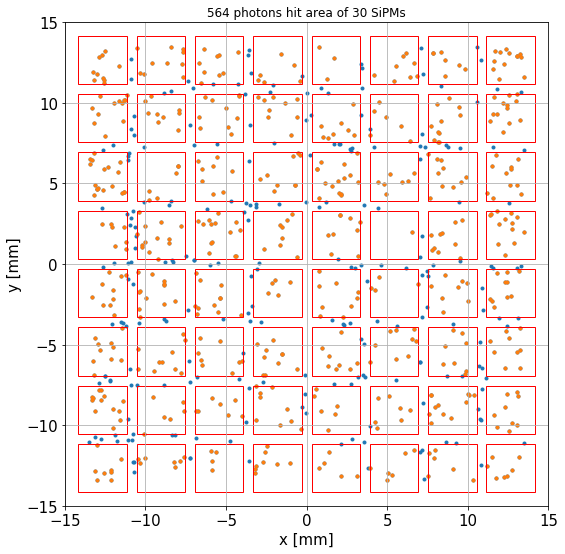

In [30]:
# in SiPM array
InSiPMarea = pd.DataFrame();
# https://www.ketek.net/wp-content/uploads/2016/12/KETEK-PA3325-WB-0808-Datasheet.pdf
Xtot = 25.32
aSiPM = 3; # [mm]
xSiPMs = np.linspace(-Xtot/2,Xtot/2,8)
ySiPMs = xSiPMs

for xSiPM in xSiPMs:
    for ySiPM in ySiPMs:
        InSiPMarea = pd.concat([InSiPMarea , 
                            PhotonsInExit[ (np.abs((PhotonsInExit.HitWaveguideExitPosX-xSiPM))< float(aSiPM)/2)                        
                                                    & (np.abs((PhotonsInExit.HitWaveguideExitPosY-ySiPM))< float(aSiPM)/2)] ])
        
figure,ax = plt.subplots(figsize=(8,8));
plt.scatter( PhotonsInExit.HitWaveguideExitPosX, PhotonsInExit.HitWaveguideExitPosY , marker='.')
plt.scatter( InSiPMarea.HitWaveguideExitPosX, InSiPMarea.HitWaveguideExitPosY , marker='.')
for xSiPM in xSiPMs:
    for ySiPM in ySiPMs:
        rect = Rectangle((xSiPM-float(aSiPM)/2,
                          ySiPM-float(aSiPM)/2),
                         aSiPM,
                         aSiPM,
                         linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

ax.set_xlabel('x [mm]',fontsize=15);
ax.set_ylabel('y [mm]',fontsize=15);
ax.set_title('%d photons hit area of 64 SiPMs'%len(InSiPMarea));
set_axes_fontsize(ax,15)
ax.set_aspect('equal')
ax.grid()
plt.tight_layout()
ax.set_xlim(-30/2,30/2);ax.set_ylim(-30/2,30/2);


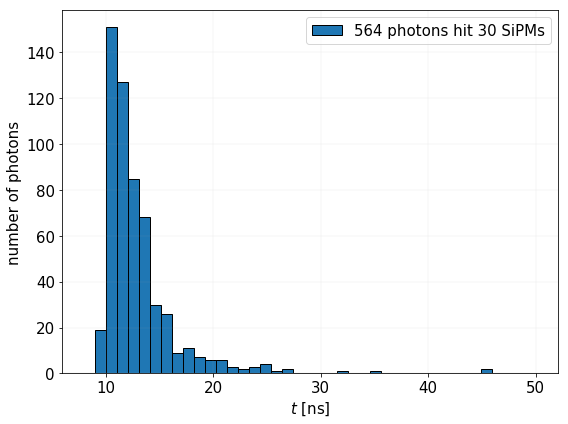

In [113]:
# time distribution of the arriving photons
time_bins=np.linspace(8,50,42)
figure,ax = plt.subplots(figsize=(8,6));
h = plt.hist( InSiPMarea.TimeFromStart*1e9 , bins=time_bins , label='%d photons hit 30 SiPMs'%len(InSiPMarea), edgecolor='black')
ax.set_xlabel('$t$ [ns]',fontsize=15);
ax.set_ylabel('number of photons',fontsize=15);
set_axes_fontsize(ax,15)
ax.grid(linewidth=0.1)
ax.legend(fontsize=15)
plt.tight_layout()

# Time resolution: 

Threshold detection of Nth = 5 photons in simulation:
- Focus on photons that hit active SiPMs within the array 
- Extract the arrival time t(n) of photon number n, accounting for SiPM fill factor and PDE. 
￼- Repeat the simulation 200 times, to form the distribution of tn. 

In [102]:
def ProtonDetectionTime( InSiPMarea, NPhotonsThreshold=5, FillFactorSiPM=0.97, PDE=0.31, fdebug=1 ):#{
    # photon detection probability = PDE * geometrical efficiency
    Pdetection = FillFactorSiPM * PDE;
    detectionTime = np.nan;

    # sort arrival times
    SortedTimes = np.sort(InSiPMarea.TimeFromStart*1e9);

    # for each photon, ask if was detected or not
    n_detected=0;
    n_photon = 0;
    while n_detected <= NPhotonsThreshold & n_photon<len(InSiPMarea): #{
        if np.random.uniform() <= Pdetection:#{
            n_detected += 1;
            detectionTime = SortedTimes[n_photon];
        #}
        n_photon += 1;
    #}

                
    if fdebug: #{        

        print "FillFactorSiPM: ", FillFactorSiPM
        print "PDE: ", PDE
        print "n_detected: ",n_detected
        print "n_photon: ",n_photon
        print "arrival time of %dth photon is %.2f ns"%(n_photon,detectionTime)
    #}    
    
    return detectionTime
#}

ProtonDetectionTime( InSiPMarea, NPhotonsThreshold=5 );

FillFactorSiPM:  0.97
PDE:  0.31
n_detected:  2
n_photon:  8
arrival time of 8th photon is 9.91 ns


In [108]:
NPhotonsThreshold=5
t_n = [];
for repIdx in np.arange(1,201,1):#{
    [InSiPM,PhotonsInExit] = ComputeNPhotonsArrivingAtWGmarginExit(WGname='WG_side27mm_length200_margin3cm',repIdx=repIdx);
    t_n.append( ProtonDetectionTime(InSiPM, NPhotonsThreshold=NPhotonsThreshold, fdebug=0 ) );
#}    
t_n

[9.71309,
 9.7575,
 9.808610000000002,
 9.72876,
 9.78474,
 10.077399999999999,
 10.0495,
 9.70005,
 9.77956,
 9.86605,
 9.93015,
 9.837309999999999,
 9.783780000000002,
 9.80761,
 9.793239999999999,
 9.79367,
 9.95497,
 9.80052,
 9.82568,
 10.024600000000001,
 9.98407,
 9.785469999999998,
 9.7382,
 9.77335,
 10.0104,
 9.86246,
 10.025400000000001,
 9.736229999999999,
 9.80812,
 9.95269,
 9.74337,
 9.7114,
 9.74822,
 9.88838,
 9.781030000000001,
 9.86365,
 9.758140000000001,
 9.922780000000001,
 9.791920000000001,
 9.7072,
 10.010900000000001,
 9.791920000000001,
 9.84543,
 9.71718,
 9.74759,
 9.7382,
 9.850370000000002,
 9.882929999999998,
 9.882929999999998,
 9.757670000000001,
 9.675229999999999,
 9.97442,
 9.92933,
 9.94025,
 10.042599999999998,
 9.74915,
 9.95531,
 9.71215,
 9.712969999999999,
 9.86789,
 9.9073,
 9.78954,
 9.78954,
 9.776610000000002,
 9.8563,
 9.830070000000001,
 9.940700000000001,
 9.75061,
 9.89332,
 9.830070000000001,
 9.76433,
 9.835379999999999,
 9.940700000

mean_t_n: 9.8300347 ,std_t_n: 0.09843032095807676


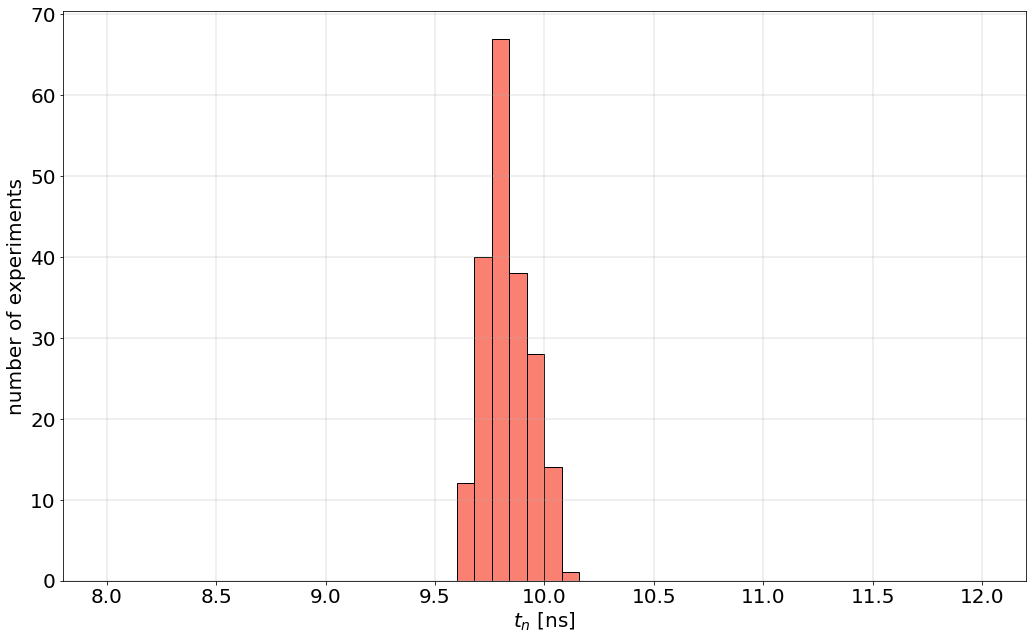

In [121]:
# distribution of the detection times
mean_t_n = np.mean(t_n)
std_t_n = np.std(t_n)

figure,ax = plt.subplots(figsize=(14.5,9));
h = plt.hist( t_n , bins=np.linspace(8,12,51), facecolor='salmon', edgecolor='black')
ax.set_xlabel('$t_{n}$ [ns]',fontsize=20);
ax.set_ylabel('number of experiments',fontsize=20);
set_axes_fontsize(ax,20)
ax.grid(linewidth=0.4)
plt.tight_layout()
print 'mean_t_n:',mean_t_n,',std_t_n:',std_t_n